In [23]:
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
from matplotlib.colors import ListedColormap
import matplotlib.ticker as ticker
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib.ticker import MaxNLocator
import seaborn as sns
import os
import gzip
import numpy as np
import scanpy as sc
import squidpy as sq
import cupy as cp
import cupyx
from cupyx.scipy.sparse import csr_matrix 
import os
import time
import rapids_singlecell as rsc
import numpy as np
import rmm
from rmm.allocators.cupy import rmm_cupy_allocator
import cupy

rmm.reinitialize(
    managed_memory=False,  # Allows oversubscription
    pool_allocator=False,  # default is False
    devices=0,  # GPU device IDs to register. By default registers only GPU 0.
)
cp.cuda.set_allocator(rmm_cupy_allocator)
import zarr
import pickle
from collections import OrderedDict
from scipy.sparse import csr_matrix
import pandas as pd
import scipy.stats as stats
from statsmodels.stats.multitest import multipletests
from scipy.sparse import csr_matrix
import scipy
import anndata
from collections import OrderedDict
from rsc_functions.utility.applyqc import applyqc
from rsc_functions.reports.plot import plot_spatial,plot_spatial_data, plot_dist

<center>Tonsil IF </center>

In [40]:
path_016 = "/data/kanferg/Sptial_Omics/playGround/Data/Tonsil/if/binned_outputs/square_016um"
pathout = "/data/kanferg/Sptial_Omics/SpatialOmicsToolkit/out_3"

In [48]:
def parquet_to_csv(path):
    '''
    Converts a Parquet file to a CSV file if the CSV file does not already exist.
    '''
    file_path = os.path.join(path,'spatial/tissue_positions_list.csv')
    if not os.path.exists(file_path):
        df = pd.read_parquet(os.path.join(path,'spatial/tissue_positions.parquet'))
        # Write to a CSV file
        df.to_csv(os.path.join(path,'spatial/tissue_positions_list.csv'), index=False)
    return
parquet_to_csv(path_016)

In [49]:
andata = sc.read_visium(path=path_016,load_images=False)
positions = pd.read_csv(os.path.join(path_016,'spatial/tissue_positions_list.csv'),index_col=0,)
positions.columns = [
            "in_tissue",
            "array_row",
            "array_col",
            "pxl_col_in_fullres",
            "pxl_row_in_fullres",
        ]
andata.obs = andata.obs.join(positions, how="left")
andata.obsm["spatial"] = andata.obs[
            ["pxl_row_in_fullres", "pxl_col_in_fullres"]
        ].to_numpy()
andata.obs.drop(
    columns=["pxl_row_in_fullres", "pxl_col_in_fullres"],
    inplace=True,
)

/usr/local/apps/rapids-singlecell/mamba/envs/rapids_singlecell/lib/python3.11/site-packages/anndata/_core/anndata.py:1820: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/usr/local/apps/rapids-singlecell/mamba/envs/rapids_singlecell/lib/python3.11/site-packages/anndata/_core/anndata.py:1820: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


In [50]:
rsc.get.anndata_to_GPU(andata)
andata.obsm['spatial'] = np.array(andata.obsm['spatial'], dtype=np.float64)
andata.var_names_make_unique()
andata.uns['config'] = OrderedDict()
andata.uns["config"]["secondary_var_names"] = andata.var_names
rsc.pp.flag_gene_family(andata, gene_family_name="MT", gene_family_prefix="MT-")
rsc.pp.calculate_qc_metrics(andata, qc_vars=["MT"])

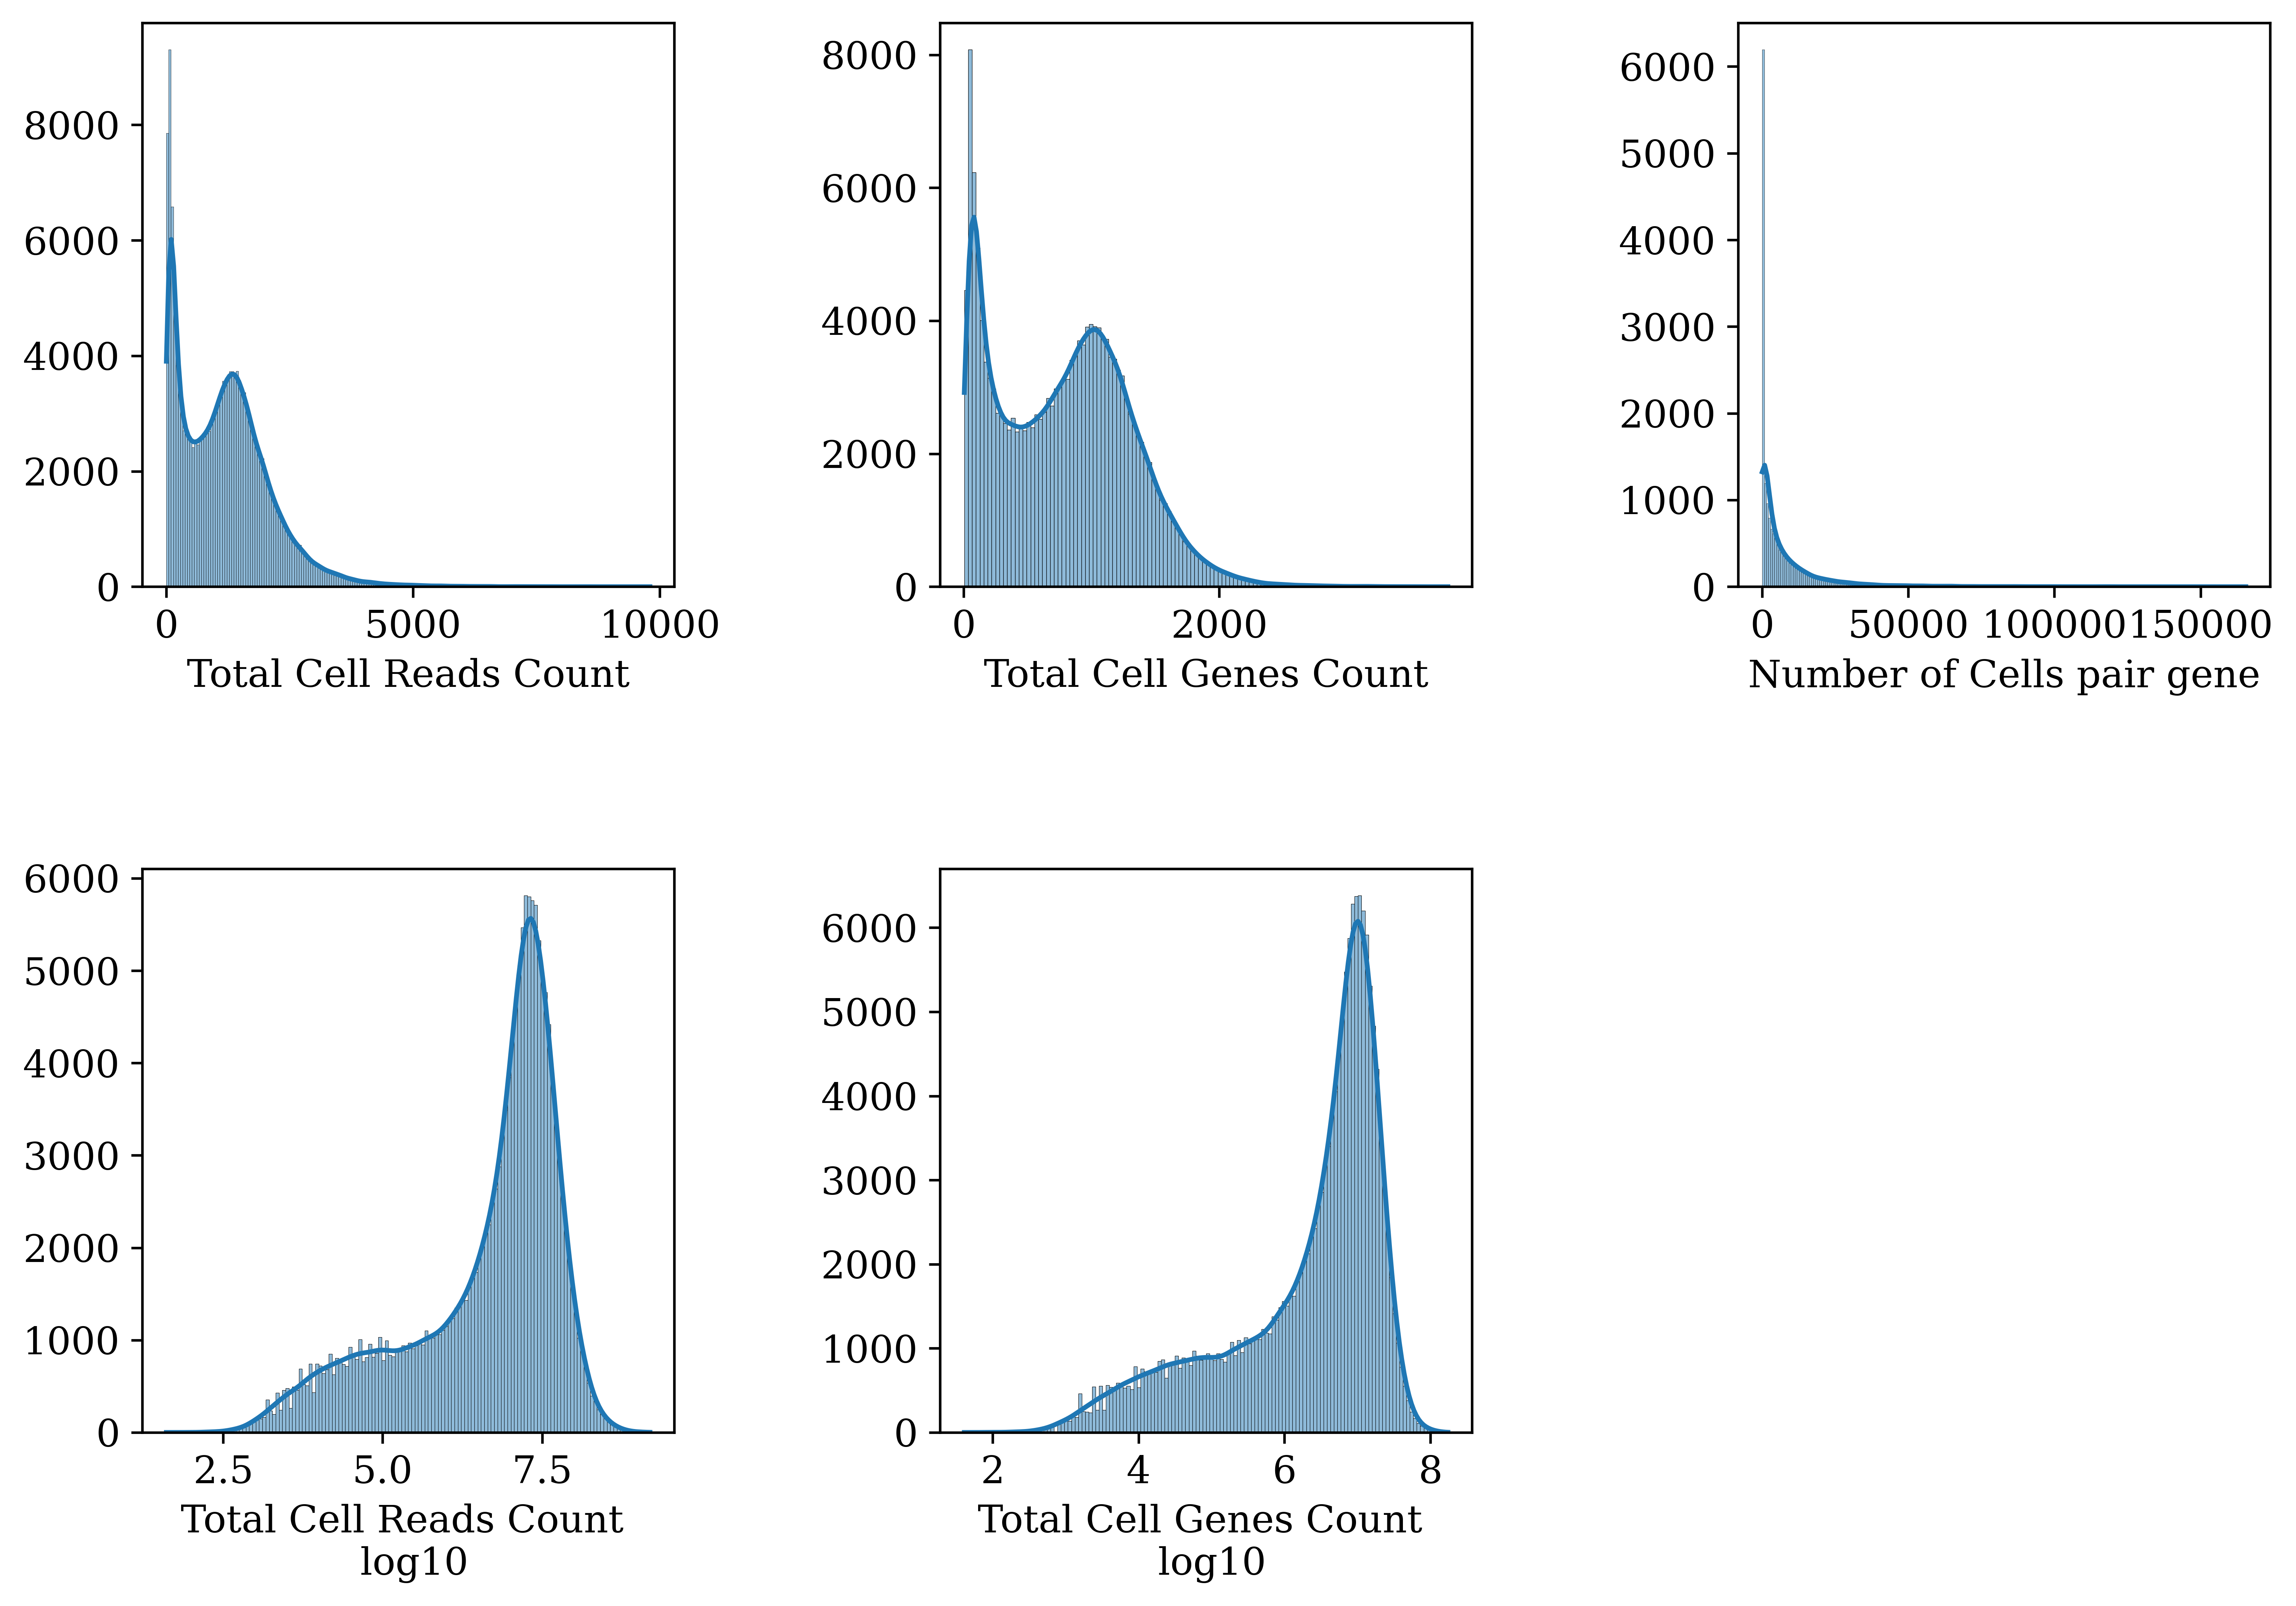

In [51]:
import warnings
# Suppress warnings in this specific code chunk
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    fig, ax = plt.subplots(2, 3, figsize=(12, 8))
    ax = np.ravel(ax)
    plot_dist(andata,column = 'total_counts',ax = ax[0],xlab = 'Total Cell Reads Count')
    plot_dist(andata,column = 'n_genes_by_counts',ax = ax[1],xlab = 'Total Cell Genes Count')
    plot_dist(andata,column = 'n_cells_by_counts',bins = 'doane', type = 'var', ax = ax[2],xlab = 'Number of Cells pair gene')
    plot_dist(andata,column = 'log1p_total_counts',ax = ax[3],xlab = 'Total Cell Reads Count \n log10')
    plot_dist(andata,column = 'log1p_n_genes_by_counts',ax = ax[4],xlab = 'Total Cell Genes Count \n log10')
    ax[5].axis('off')
    plt.subplots_adjust(wspace = 0.5, hspace=0.5)

In [52]:
plt.rcParams['figure.dpi'] = 600
plt.rcParams['font.family'] = ['serif']
plt.rcParams['font.size'] = 12
plt.rcParams['axes.labelsize'] = 12
plt.rcParams['axes.titlesize'] = 12
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12
fig, ax = plt.subplots(1,1, figsize=(15, 15))
with PdfPages(os.path.join(pathout, 'Tonsil_IF_Report_spatial_map_plot_total_count.pdf')) as pdf:
    plot_spatial_data(andata, 'total_counts', fig = fig , ax = ax ,set_xlabel_cbar = 'Total Count',size = 1)
    plt.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.2)
    pdf.savefig()
    plt.close()   

In [53]:
andata

AnnData object with n_obs × n_vars = 170034 × 18085
    obs: 'in_tissue', 'array_row', 'array_col', 'n_genes_by_counts', 'total_counts', 'log1p_n_genes_by_counts', 'log1p_total_counts', 'total_counts_MT', 'pct_counts_MT', 'log1p_total_counts_MT'
    var: 'gene_ids', 'feature_types', 'genome', 'MT', 'n_cells_by_counts', 'total_counts', 'mean_counts', 'pct_dropout_by_counts', 'log1p_total_counts', 'log1p_mean_counts'
    uns: 'spatial', 'config'
    obsm: 'spatial'

In [54]:
rsc.pp.filter_cells(andata, min_count=50,qc_var = 'total_counts')
rsc.pp.filter_genes(andata, min_count=50,qc_var = 'total_counts')
rsc.pp.filter_genes(andata, max_count=50_000)
andata.layers['counts'] = andata.X.copy()
rsc.pp.normalize_total(andata)
rsc.pp.log1p(andata)
andata.layers['log'] = andata.X.copy()
rsc.pp.highly_variable_genes(andata, n_top_genes=2000, flavor="seurat_v3", layer="log")
andata = andata[:, andata.var["highly_variable"]]
rsc.pp.scale(andata, max_value=10)
rsc.pp.pca(andata, n_comps=30,random_state=1337, use_highly_variable=False)

filtered out 7386 cells
filtered out 3400 genes based on total_counts
filtered out 298 genes based on n_cells_by_counts


/usr/local/apps/rapids-singlecell/mamba/envs/rapids_singlecell/lib/python3.11/site-packages/rapids_singlecell/preprocessing/_hvg.py:517: UserWarning: `flavor='seurat_v3'` expects raw count data, but non-integers were found.
  warnings.warn(
/usr/local/apps/rapids-singlecell/mamba/envs/rapids_singlecell/lib/python3.11/site-packages/rapids_singlecell/preprocessing/_scale.py:71: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)
/usr/local/apps/rapids-singlecell/mamba/envs/rapids_singlecell/lib/python3.11/site-packages/scanpy/preprocessing/_pca.py:374: FutureWarning: Argument `use_highly_variable` is deprecated, consider using the mask argument. Use_highly_variable=True can be called through mask_var="highly_variable". Use_highly_variable=False can be called through mask_var=None
  warn(msg, FutureWarning)


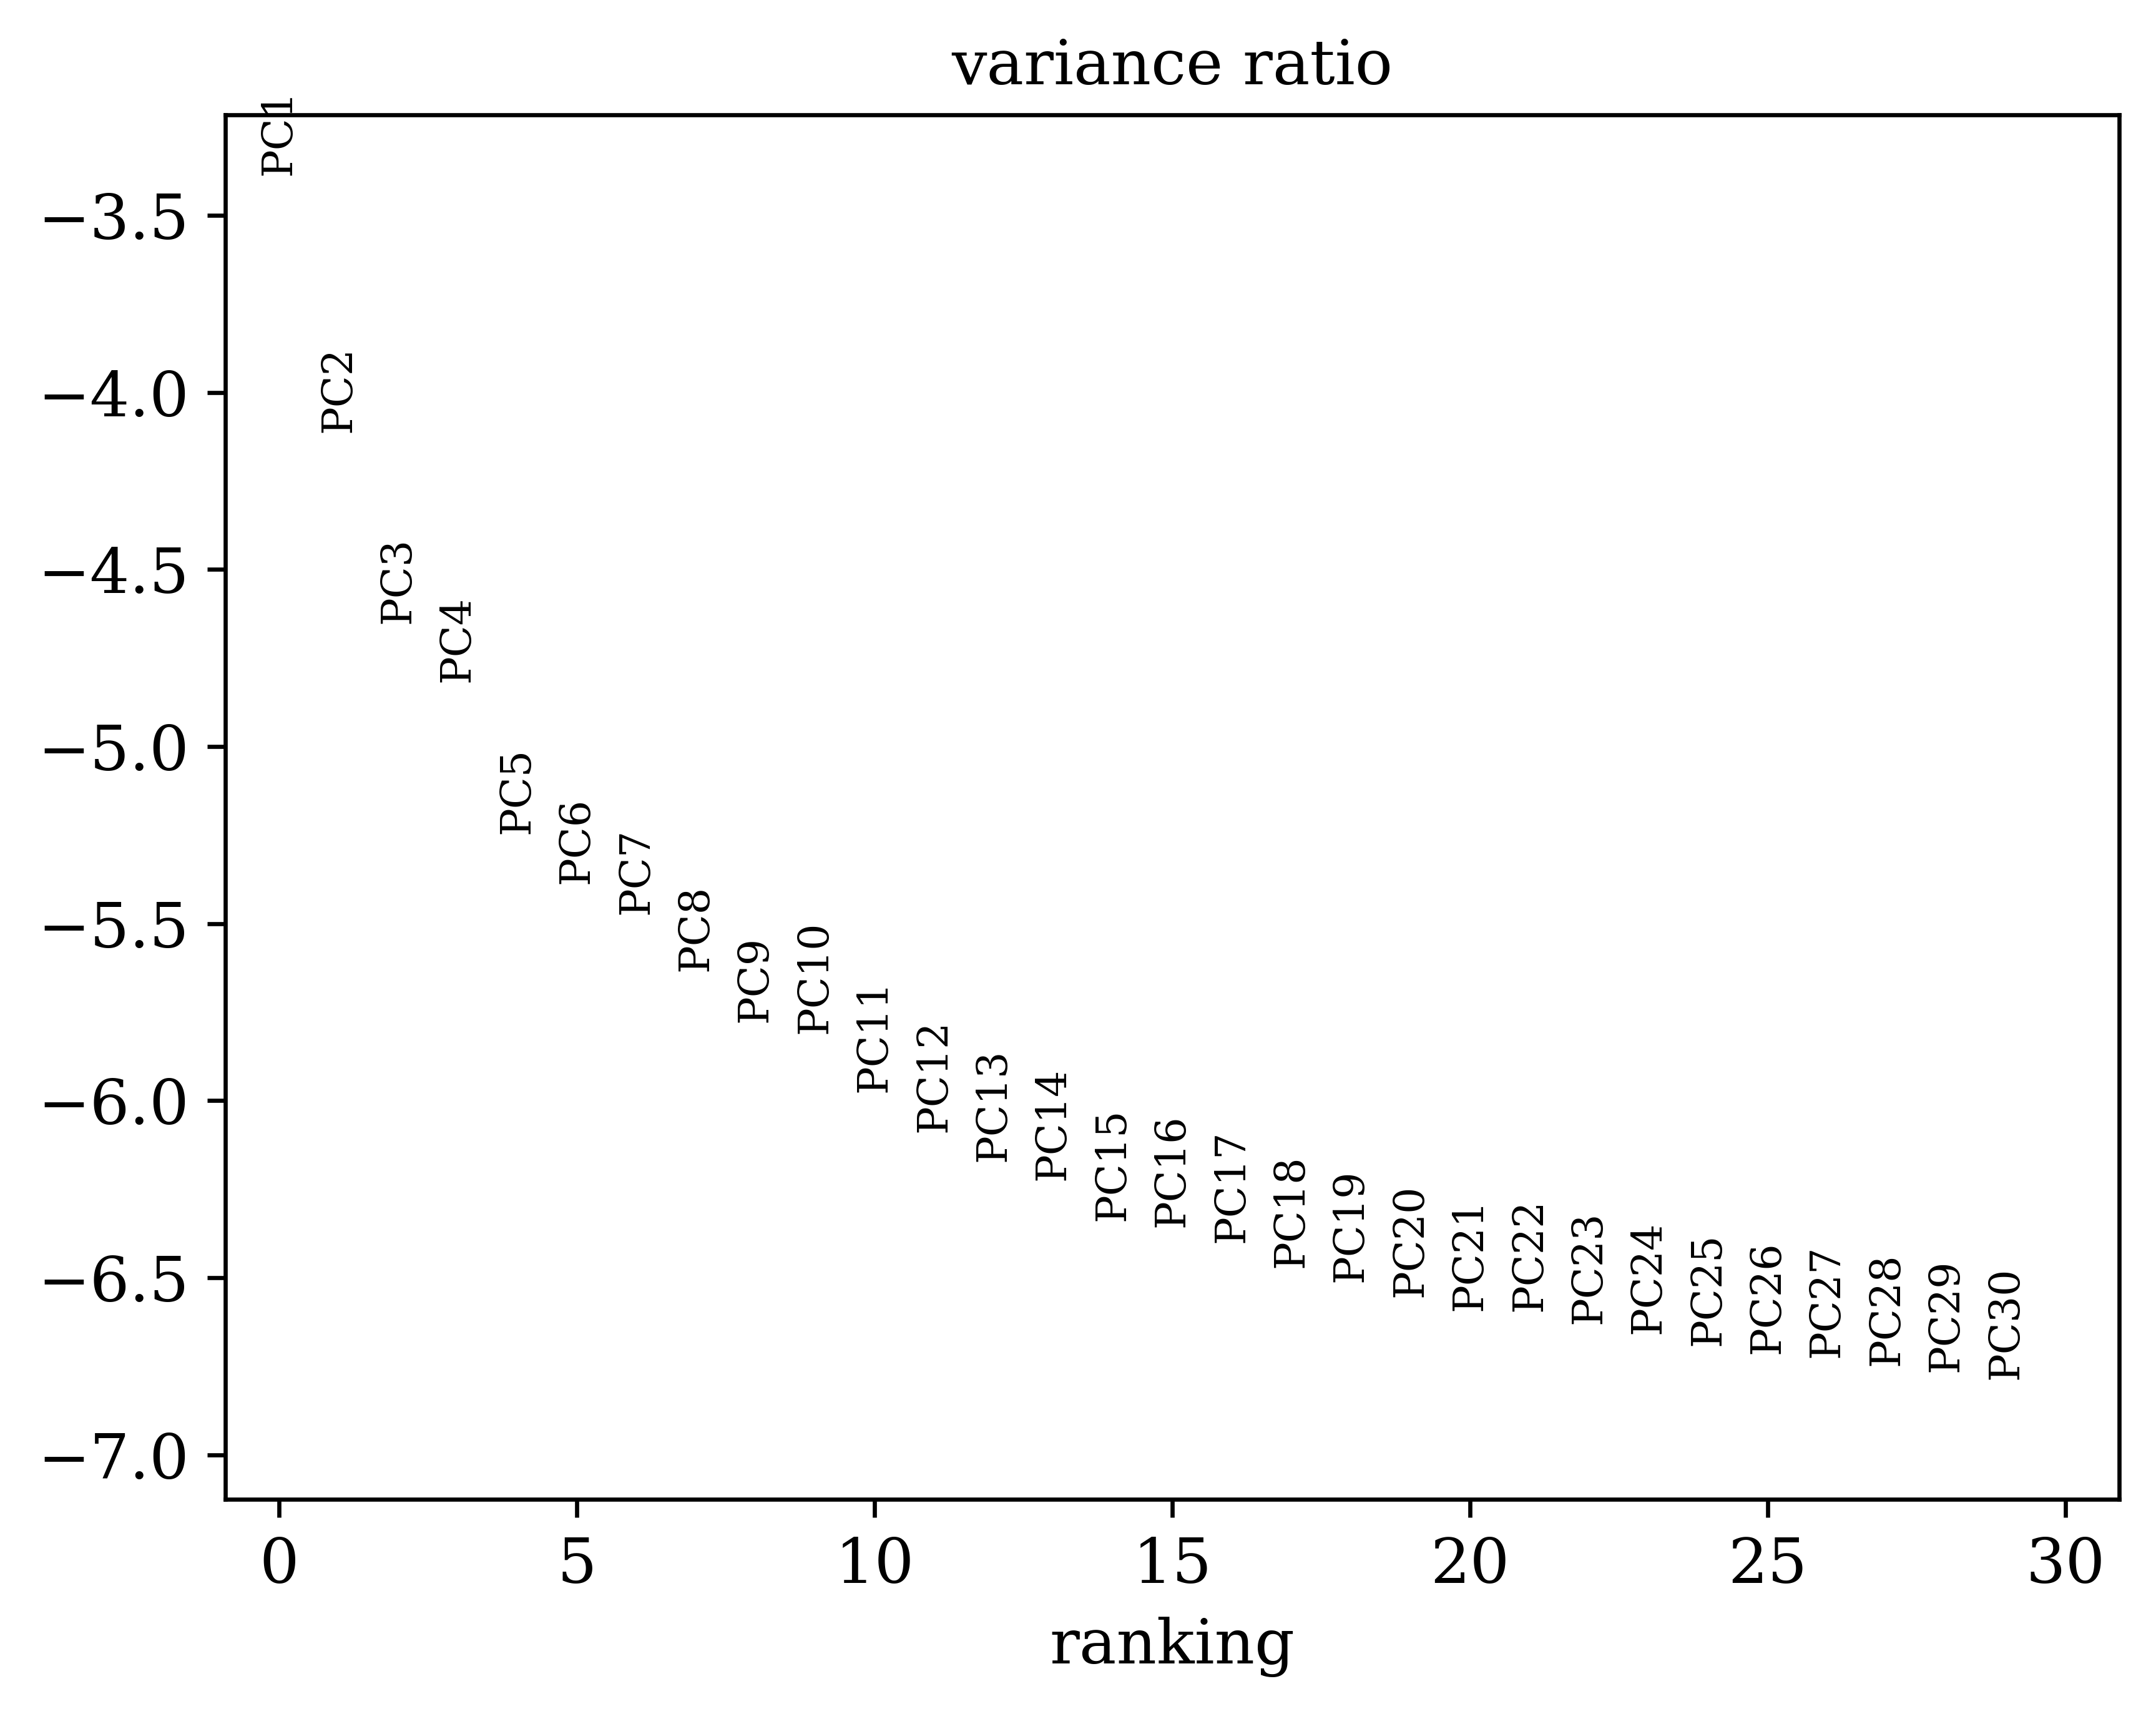

In [60]:
sc.pl.pca_variance_ratio(andata, log=True, n_pcs=30)

In [56]:
rsc.pp.neighbors(andata, n_pcs=15, use_rep='X_pca', n_neighbors=25)

In [59]:
resolutions = [0.5,0.8,1,2]
for res in resolutions:
    rsc.tl.leiden(andata, random_state=1337, resolution=res, key_added='cluster')
    with PdfPages(os.path.join(pathout, f'Tonsil_IF_Report_spatial_map_plot_{res}.pdf')) as pdf:
        fig, ax = plt.subplots(1, 1, figsize=(15,15))
        plt.rcParams['figure.dpi'] = 600
        plt.rcParams['font.family'] = ['serif']
        plt.rcParams['font.size'] = 12
        plt.rcParams['axes.labelsize'] = 12
        plt.rcParams['axes.titlesize'] = 12
        plt.rcParams['xtick.labelsize'] = 12
        plt.rcParams['ytick.labelsize'] = 12
        clusterColorMap = plot_spatial(andata,ax = ax, features = None, title = f'resolution: {res}',markerscale = 5, xlab = '',ylab ='',size = 0.4)
        plt.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.2)
        pdf.savefig()
        plt.close()
    print(f'{res}')

0.5
0.8
1
2


In [63]:
from cupyx.scipy.sparse import csr_matrix
def save_matrix(matrix,pathout,file_name = "obsp_distances_large.npz"):
    cp.savez(os.path.join(pathout, file_name),  
            data=matrix.data,  
            indices=matrix.indices,  
            indptr=matrix.indptr,  
            shape=matrix.shape)
sparse_matrix = andata.obsp['distances']
save_matrix(matrix = sparse_matrix,pathout = pathout,file_name = "obsp_distances_Tonsil_IF.npz")
sparse_matrix = andata.obsp['connectivities']
save_matrix(matrix = sparse_matrix,pathout = pathout,file_name = "obsp_connectivities_Tonsil_IF.npz")

In [64]:
andata_save = andata.copy()
for column in andata_save.obs.columns:
    print(f"Column '{column}' has data type: {andata_save.obs[column].dtype}")

Column 'in_tissue' has data type: int64
Column 'array_row' has data type: int64
Column 'array_col' has data type: int64
Column 'n_genes_by_counts' has data type: int32
Column 'total_counts' has data type: float32
Column 'log1p_n_genes_by_counts' has data type: float64
Column 'log1p_total_counts' has data type: float32
Column 'total_counts_MT' has data type: float32
Column 'pct_counts_MT' has data type: float32
Column 'log1p_total_counts_MT' has data type: float32
Column 'cluster' has data type: category


In [69]:
andata_save

AnnData object with n_obs × n_vars = 162648 × 2000
    obs: 'in_tissue', 'array_row', 'array_col', 'n_genes_by_counts', 'total_counts', 'log1p_n_genes_by_counts', 'log1p_total_counts', 'total_counts_MT', 'pct_counts_MT', 'log1p_total_counts_MT', 'cluster'
    var: 'gene_ids', 'feature_types', 'genome', 'MT', 'n_cells_by_counts', 'total_counts', 'mean_counts', 'pct_dropout_by_counts', 'log1p_total_counts', 'log1p_mean_counts', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'mean', 'std'
    uns: 'spatial', 'config', 'log1p', 'hvg', 'pca', 'neighbors', 'leiden'
    obsm: 'spatial', 'X_pca'
    varm: 'PCs'
    layers: 'counts', 'log'
    obsp: 'distances', 'connectivities'

In [71]:
del andata_save.uns
# del andata_save.obsm
del andata_save.varm
# del andata_save.layers
del andata_save.obsp
andata_save.write_h5ad(os.path.join(pathout, "andata_Tonsil_IF.h5ad"))

<center>Tonsil no-IF </center>

In [72]:
path_016 = "/data/kanferg/Sptial_Omics/playGround/Data/Tonsil/no_if/binned_outputs/square_016um"
pathout = "/data/kanferg/Sptial_Omics/SpatialOmicsToolkit/out_3"

In [74]:
def parquet_to_csv(path):
    '''
    Converts a Parquet file to a CSV file if the CSV file does not already exist.
    '''
    file_path = os.path.join(path,'spatial/tissue_positions_list.csv')
    if not os.path.exists(file_path):
        df = pd.read_parquet(os.path.join(path,'spatial/tissue_positions.parquet'))
        # Write to a CSV file
        df.to_csv(os.path.join(path,'spatial/tissue_positions_list.csv'), index=False)
    return
parquet_to_csv(path_016)
andata = sc.read_visium(path=path_016,load_images=False)
positions = pd.read_csv(os.path.join(path_016,'spatial/tissue_positions_list.csv'),index_col=0,)
positions.columns = [
            "in_tissue",
            "array_row",
            "array_col",
            "pxl_col_in_fullres",
            "pxl_row_in_fullres",
        ]
andata.obs = andata.obs.join(positions, how="left")
andata.obsm["spatial"] = andata.obs[
            ["pxl_row_in_fullres", "pxl_col_in_fullres"]
        ].to_numpy()
andata.obs.drop(
    columns=["pxl_row_in_fullres", "pxl_col_in_fullres"],
    inplace=True,
)

/usr/local/apps/rapids-singlecell/mamba/envs/rapids_singlecell/lib/python3.11/site-packages/anndata/_core/anndata.py:1820: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/usr/local/apps/rapids-singlecell/mamba/envs/rapids_singlecell/lib/python3.11/site-packages/anndata/_core/anndata.py:1820: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


In [75]:
rsc.get.anndata_to_GPU(andata)
andata.obsm['spatial'] = np.array(andata.obsm['spatial'], dtype=np.float64)
andata.var_names_make_unique()
andata.uns['config'] = OrderedDict()
andata.uns["config"]["secondary_var_names"] = andata.var_names
rsc.pp.flag_gene_family(andata, gene_family_name="MT", gene_family_prefix="MT-")
rsc.pp.calculate_qc_metrics(andata, qc_vars=["MT"])

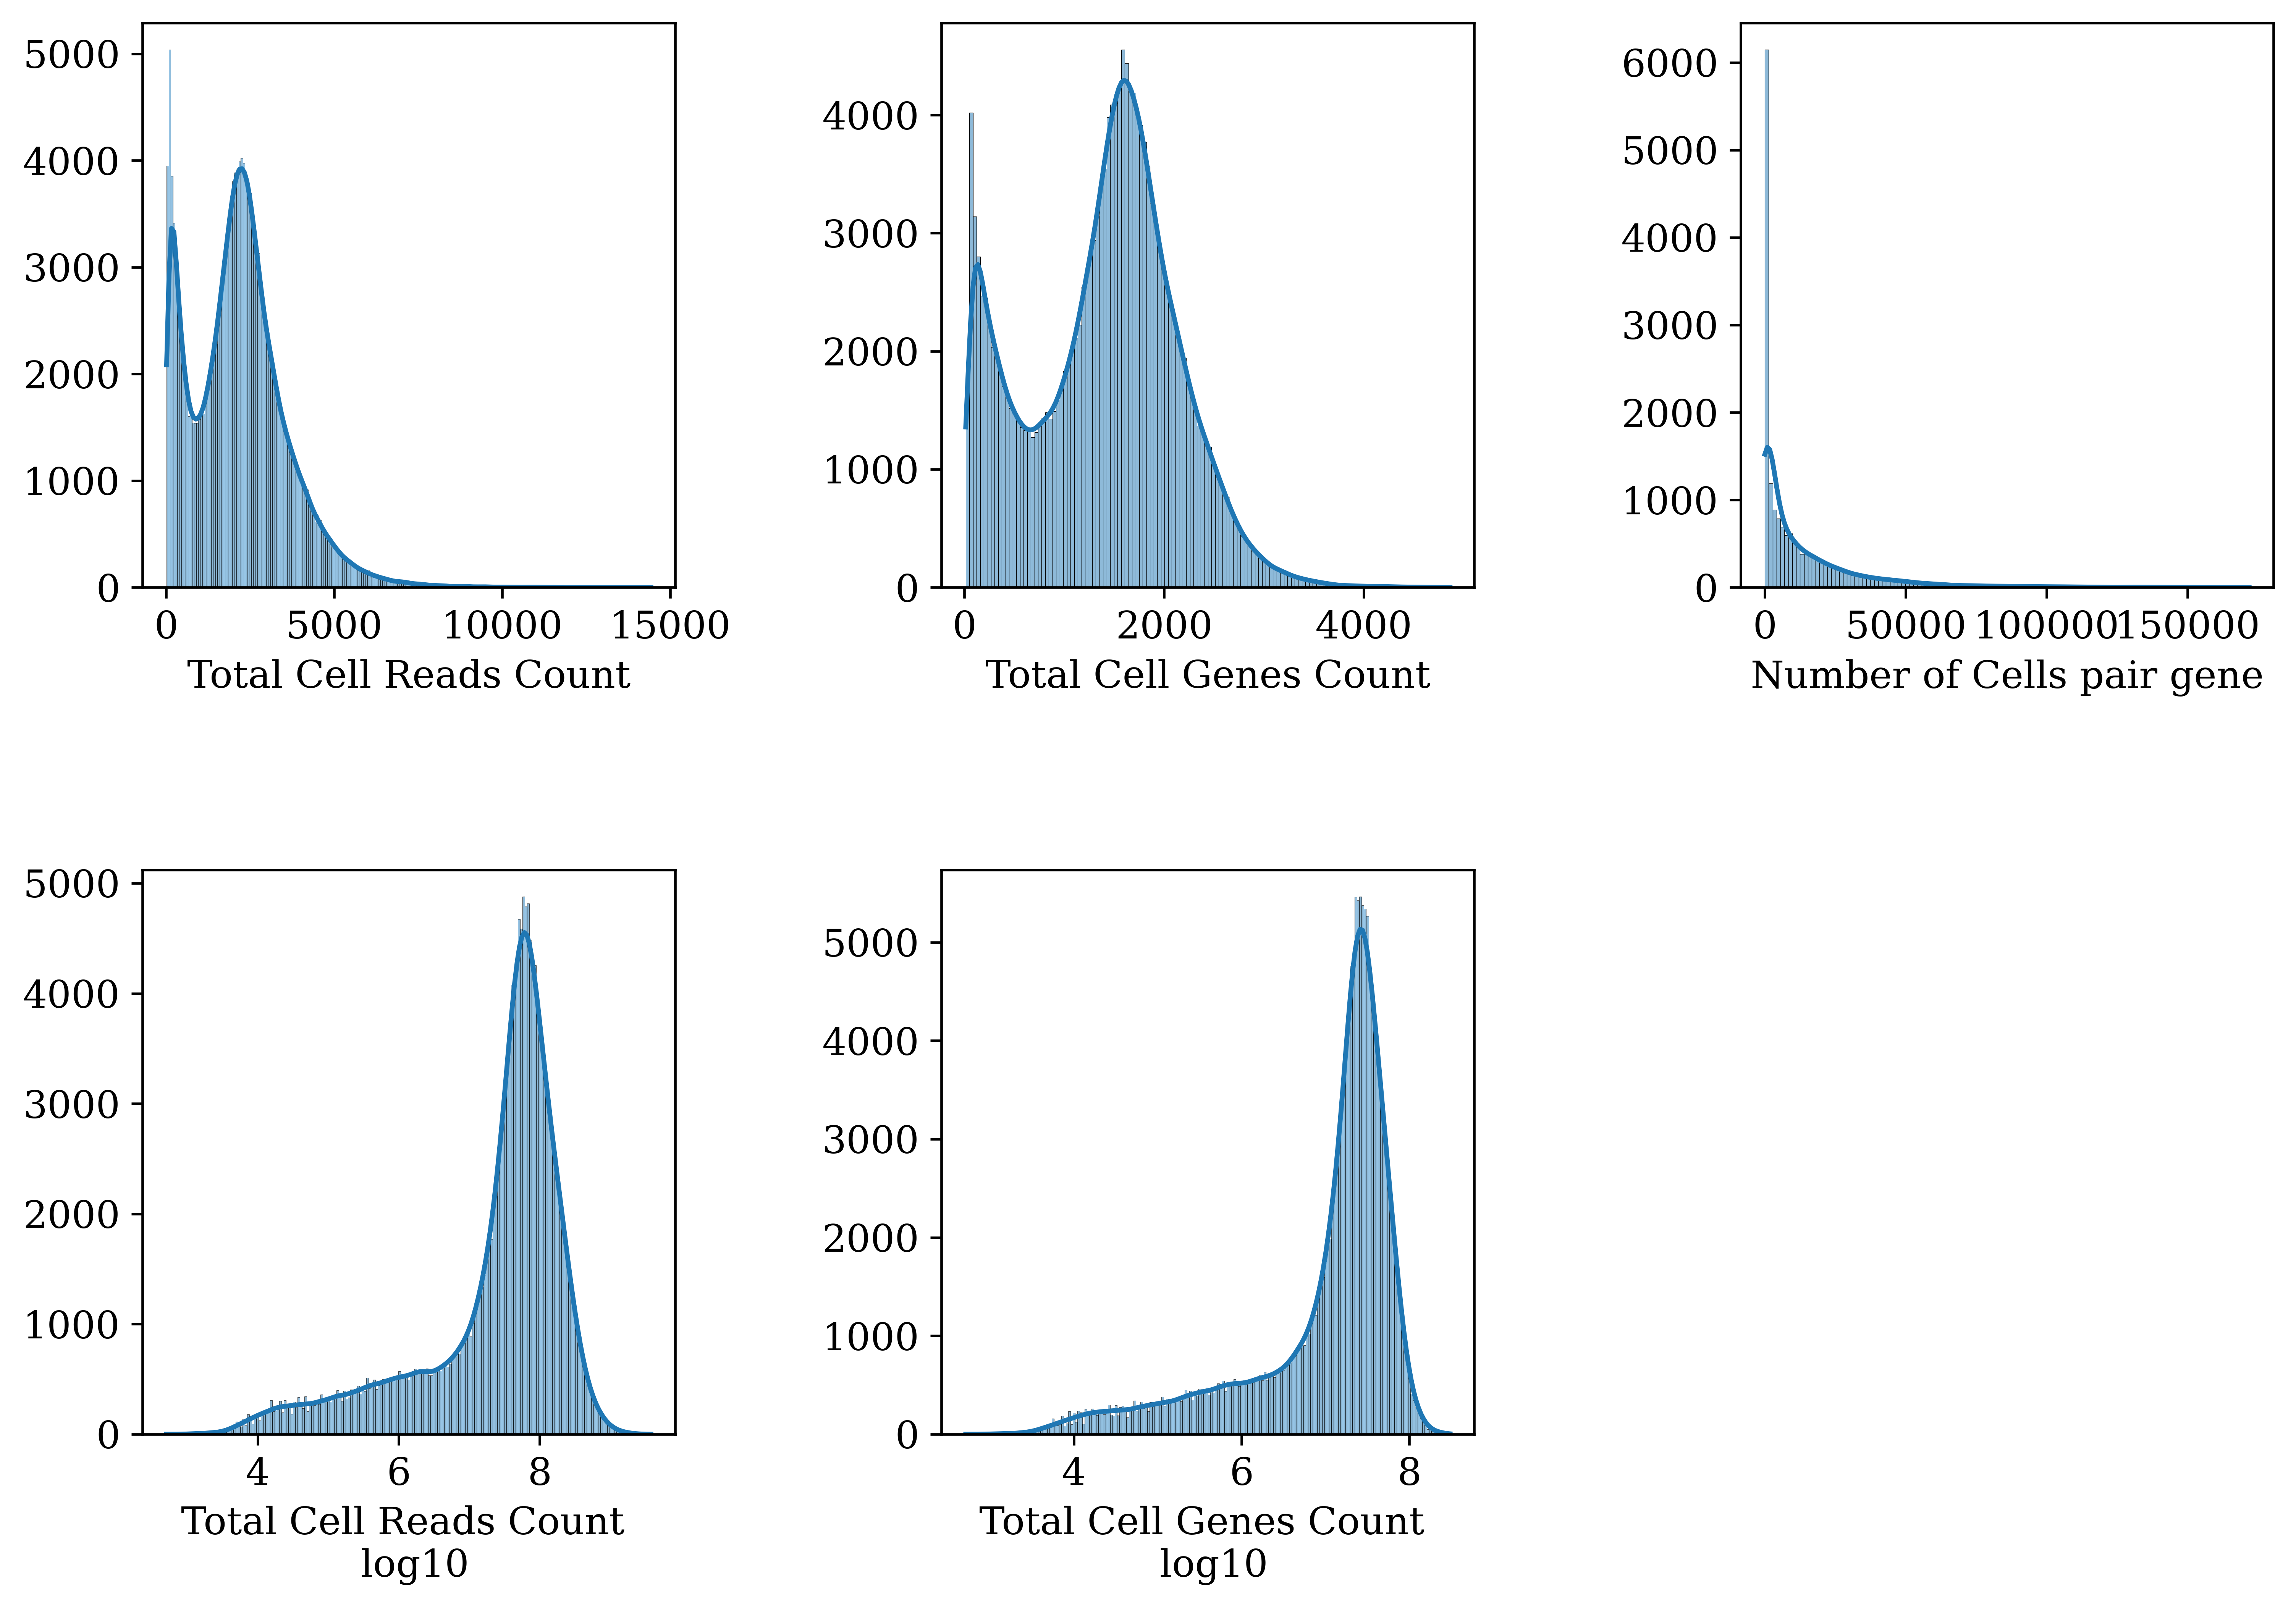

In [76]:
import warnings
# Suppress warnings in this specific code chunk
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    fig, ax = plt.subplots(2, 3, figsize=(12, 8))
    ax = np.ravel(ax)
    plot_dist(andata,column = 'total_counts',ax = ax[0],xlab = 'Total Cell Reads Count')
    plot_dist(andata,column = 'n_genes_by_counts',ax = ax[1],xlab = 'Total Cell Genes Count')
    plot_dist(andata,column = 'n_cells_by_counts',bins = 'doane', type = 'var', ax = ax[2],xlab = 'Number of Cells pair gene')
    plot_dist(andata,column = 'log1p_total_counts',ax = ax[3],xlab = 'Total Cell Reads Count \n log10')
    plot_dist(andata,column = 'log1p_n_genes_by_counts',ax = ax[4],xlab = 'Total Cell Genes Count \n log10')
    ax[5].axis('off')
    plt.subplots_adjust(wspace = 0.5, hspace=0.5)

In [77]:
plt.rcParams['figure.dpi'] = 600
plt.rcParams['font.family'] = ['serif']
plt.rcParams['font.size'] = 12
plt.rcParams['axes.labelsize'] = 12
plt.rcParams['axes.titlesize'] = 12
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12
fig, ax = plt.subplots(1,1, figsize=(15, 15))
with PdfPages(os.path.join(pathout, 'Tonsil_noIF_Report_spatial_map_plot_total_count.pdf')) as pdf:
    plot_spatial_data(andata, 'total_counts', fig = fig , ax = ax ,set_xlabel_cbar = 'Total Count',size = 1)
    plt.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.2)
    pdf.savefig()
    plt.close()   

In [78]:
rsc.pp.filter_cells(andata, min_count=50,qc_var = 'total_counts')
rsc.pp.filter_genes(andata, min_count=50,qc_var = 'total_counts')
rsc.pp.filter_genes(andata, max_count=50_000)
andata.layers['counts'] = andata.X.copy()
rsc.pp.normalize_total(andata)
rsc.pp.log1p(andata)
andata.layers['log'] = andata.X.copy()
rsc.pp.highly_variable_genes(andata, n_top_genes=2000, flavor="seurat_v3", layer="log")
andata = andata[:, andata.var["highly_variable"]]
rsc.pp.scale(andata, max_value=10)
rsc.pp.pca(andata, n_comps=30,random_state=1337, use_highly_variable=False)

filtered out 1219 cells
filtered out 2713 genes based on total_counts
filtered out 1036 genes based on n_cells_by_counts


/usr/local/apps/rapids-singlecell/mamba/envs/rapids_singlecell/lib/python3.11/site-packages/rapids_singlecell/preprocessing/_hvg.py:517: UserWarning: `flavor='seurat_v3'` expects raw count data, but non-integers were found.
  warnings.warn(
/usr/local/apps/rapids-singlecell/mamba/envs/rapids_singlecell/lib/python3.11/site-packages/rapids_singlecell/preprocessing/_scale.py:71: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)
/usr/local/apps/rapids-singlecell/mamba/envs/rapids_singlecell/lib/python3.11/site-packages/scanpy/preprocessing/_pca.py:374: FutureWarning: Argument `use_highly_variable` is deprecated, consider using the mask argument. Use_highly_variable=True can be called through mask_var="highly_variable". Use_highly_variable=False can be called through mask_var=None
  warn(msg, FutureWarning)


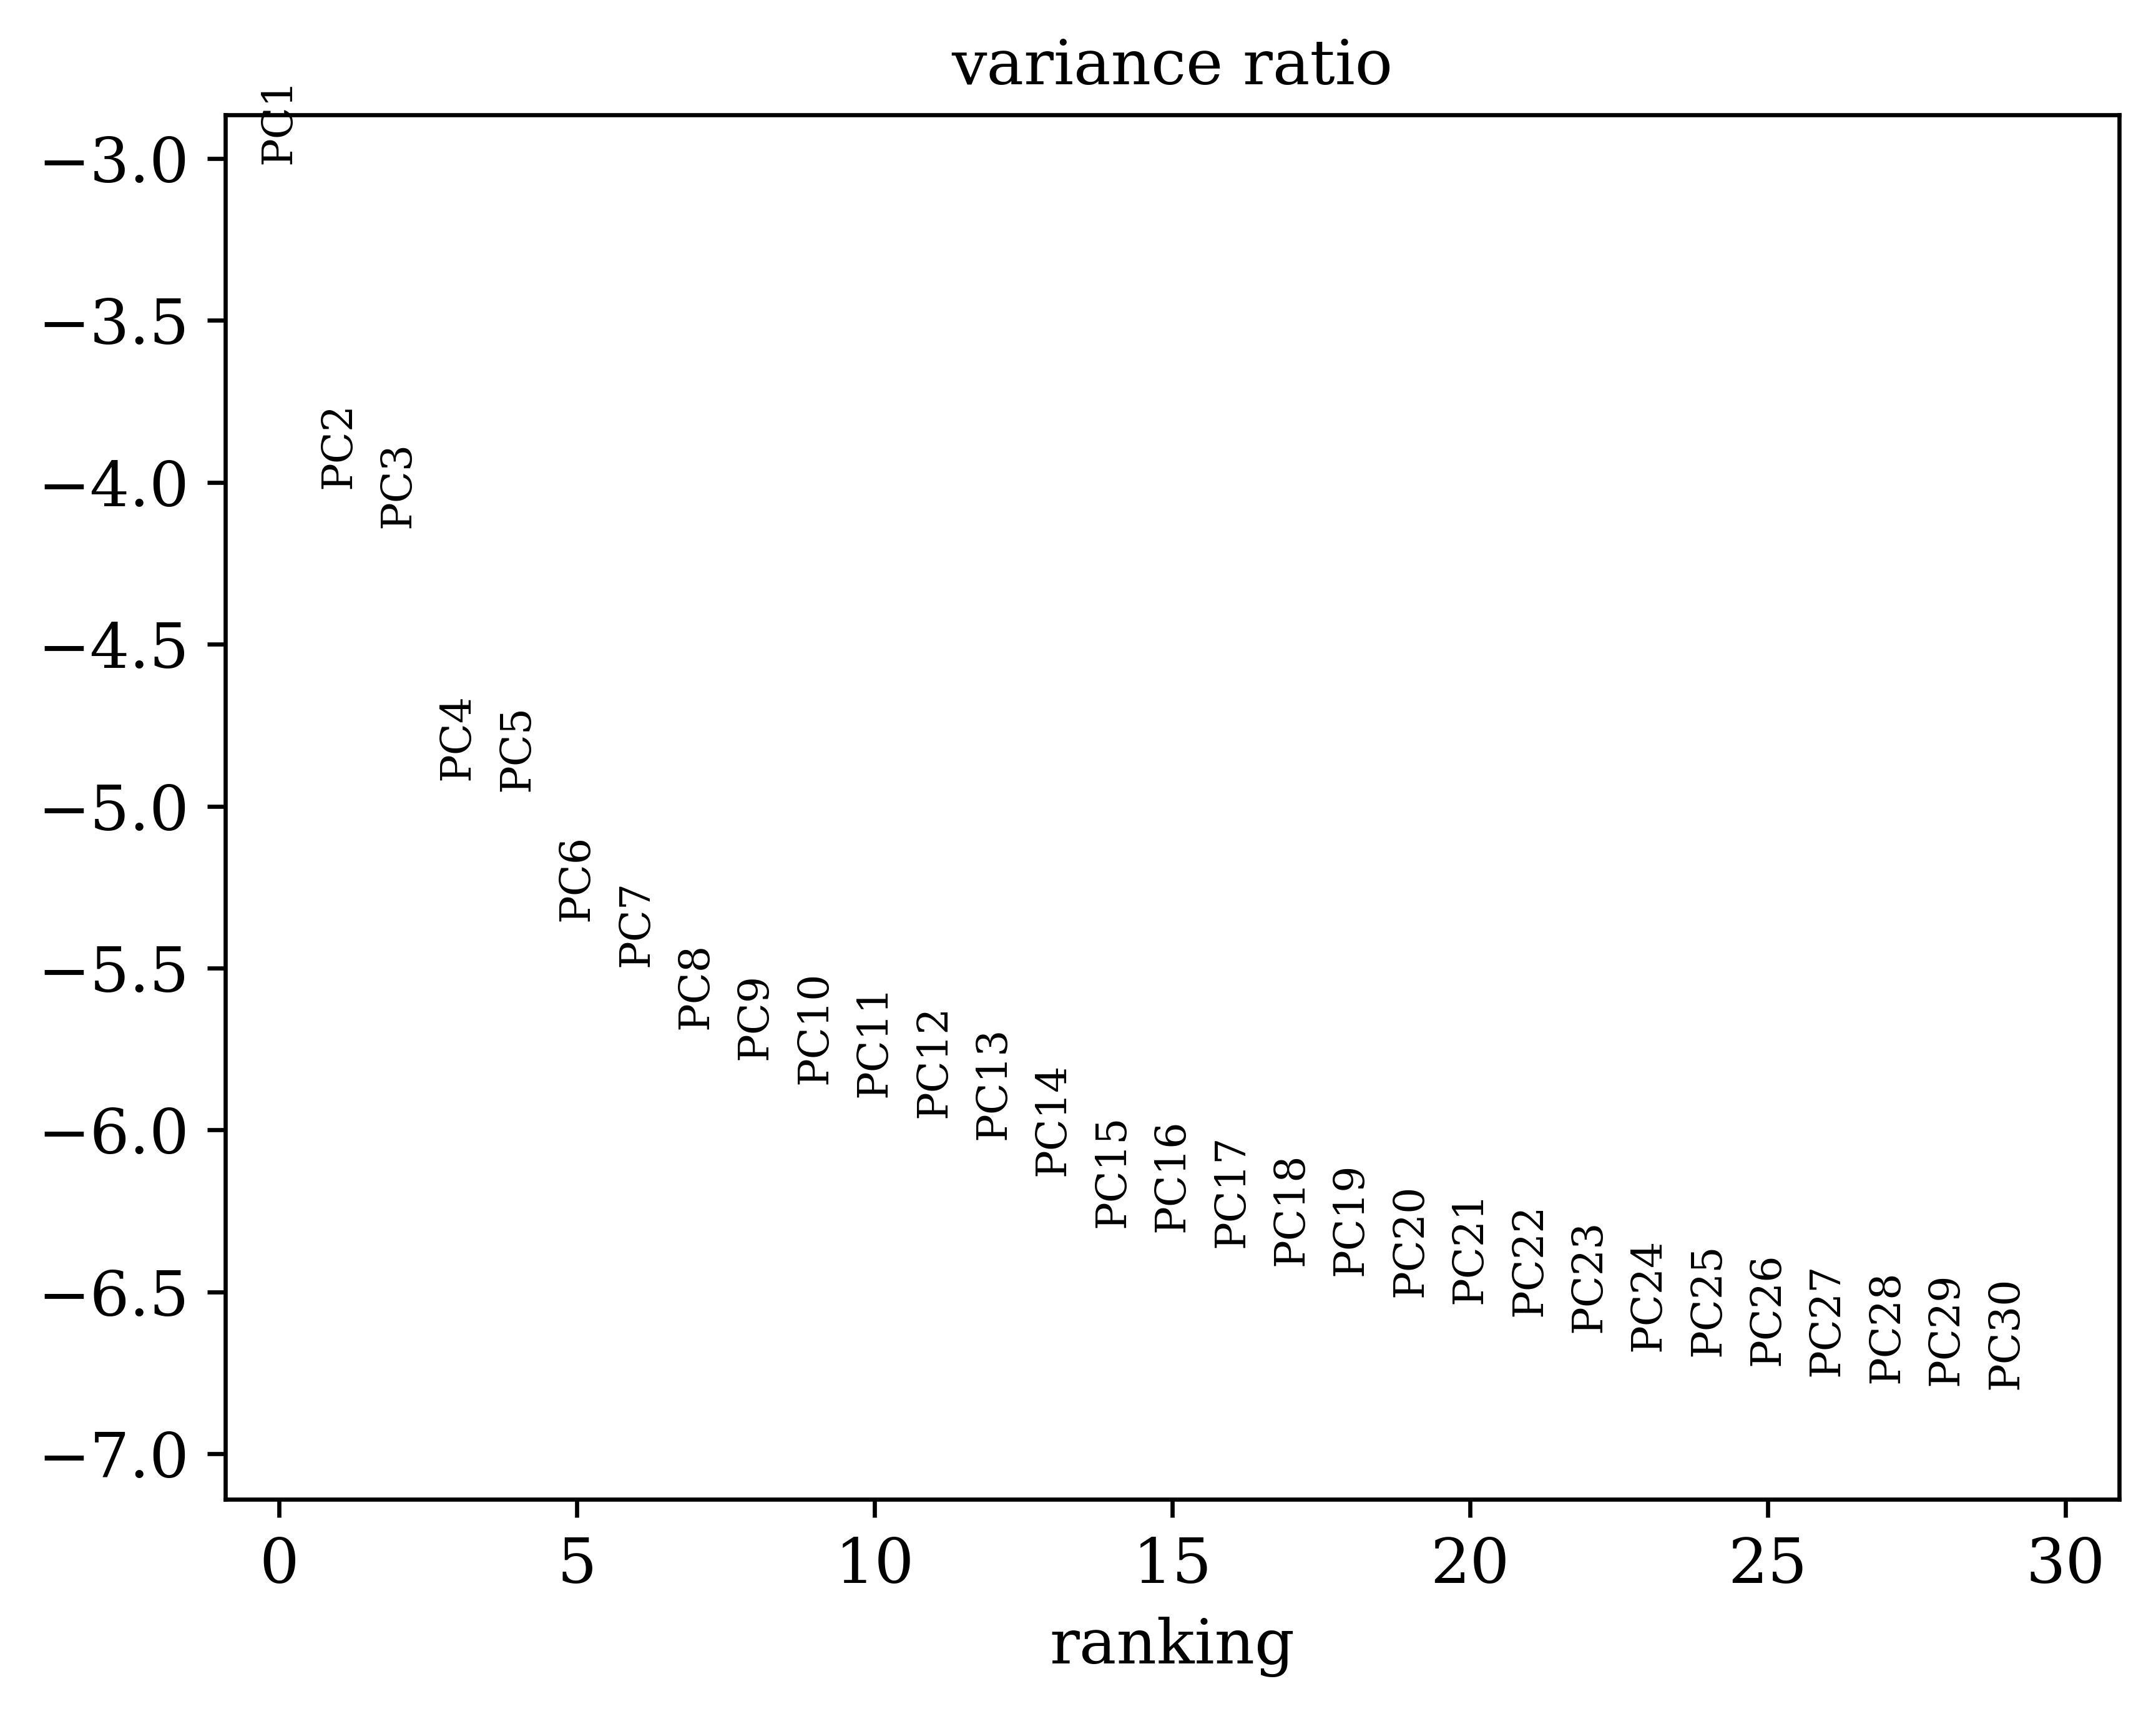

In [80]:
sc.pl.pca_variance_ratio(andata, log=True, n_pcs=30)

In [81]:
rsc.pp.neighbors(andata, n_pcs=15, use_rep='X_pca', n_neighbors=25)

In [82]:
res = 0.5
rsc.tl.leiden(andata, random_state=1337, resolution=0.5, key_added='cluster')
with PdfPages(os.path.join(pathout, f'Tonsil_noIF_Report_spatial_map_plot_{res}.pdf')) as pdf:
    fig, ax = plt.subplots(1, 1, figsize=(15,15))
    plt.rcParams['figure.dpi'] = 600
    plt.rcParams['font.family'] = ['serif']
    plt.rcParams['font.size'] = 12
    plt.rcParams['axes.labelsize'] = 12
    plt.rcParams['axes.titlesize'] = 12d
    plt.rcParams['xtick.labelsize'] = 12
    plt.rcParams['ytick.labelsize'] = 12
    clusterColorMap = plot_spatial(andata,ax = ax, features = None, title = f'resolution: {res}',markerscale = 5, xlab = '',ylab ='',size = 0.4)
    plt.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.2)
    pdf.savefig()
    plt.close()

In [83]:
from cupyx.scipy.sparse import csr_matrix
def save_matrix(matrix,pathout,file_name = "obsp_distances_large.npz"):
    cp.savez(os.path.join(pathout, file_name),  
            data=matrix.data,  
            indices=matrix.indices,  
            indptr=matrix.indptr,  
            shape=matrix.shape)
sparse_matrix = andata.obsp['distances']
save_matrix(matrix = sparse_matrix,pathout = pathout,file_name = "obsp_distances_Tonsil_noIF.npz")
sparse_matrix = andata.obsp['connectivities']
save_matrix(matrix = sparse_matrix,pathout = pathout,file_name = "obsp_connectivities_Tonsil_noIF.npz")

In [84]:
andata_save

AnnData object with n_obs × n_vars = 162648 × 2000
    obs: 'in_tissue', 'array_row', 'array_col', 'n_genes_by_counts', 'total_counts', 'log1p_n_genes_by_counts', 'log1p_total_counts', 'total_counts_MT', 'pct_counts_MT', 'log1p_total_counts_MT', 'cluster'
    var: 'gene_ids', 'feature_types', 'genome', 'MT', 'n_cells_by_counts', 'total_counts', 'mean_counts', 'pct_dropout_by_counts', 'log1p_total_counts', 'log1p_mean_counts', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'mean', 'std'
    obsm: 'spatial', 'X_pca'
    layers: 'counts', 'log'

In [85]:
andata_save = andata.copy()
for column in andata_save.obs.columns:
    print(f"Column '{column}' has data type: {andata_save.obs[column].dtype}")

Column 'in_tissue' has data type: int64
Column 'array_row' has data type: int64
Column 'array_col' has data type: int64
Column 'n_genes_by_counts' has data type: int32
Column 'total_counts' has data type: float32
Column 'log1p_n_genes_by_counts' has data type: float64
Column 'log1p_total_counts' has data type: float32
Column 'total_counts_MT' has data type: float32
Column 'pct_counts_MT' has data type: float32
Column 'log1p_total_counts_MT' has data type: float32
Column 'cluster' has data type: category


In [86]:
del andata_save.uns
# del andata_save.obsm
del andata_save.varm
# del andata_save.layers
del andata_save.obsp
andata_save.write_h5ad(os.path.join(pathout, "andata_Tonsil_noIF.h5ad"))

<center><H1>Harmony

source mycond
<br>
mamba activate stlearn-env
<br>
jupyter notebook --ip localhost --port $PORT1 --no-browser 

In [1]:
import cupy as cp
import cupyx
import scanpy as sc
import stlearn as st
import scanpy as sc
import numpy as np
from cupyx.scipy.sparse import csr_matrix
import os
from PIL import Image
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.backends.backend_pdf import PdfPages
import seaborn as sns
import random
import pandas as pd

/gpfs/gsfs10/users/kanferg/conda/envs/stlearn-env/lib/python3.8/site-packages/stlearn/tools/microenv/cci/het.py:192: NumbaDeprecationWarning: The keyword argument 'nopython=False' was supplied. From Numba 0.59.0 the default is being changed to True and use of 'nopython=False' will raise a warning as the argument will have no effect. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @jit(parallel=True, nopython=False)


In [2]:
pathout = "/data/kanferg/Sptial_Omics/SpatialOmicsToolkit/out_3"
andata_IF = sc.read_h5ad(os.path.join(pathout, "andata_Tonsil_IF.h5ad"))
andata_IF.obs['batch'] = 'yes'
andata_noIF = sc.read_h5ad(os.path.join(pathout, "andata_Tonsil_noIF.h5ad"))
andata_noIF.obs['batch'] = 'no'

In [3]:
adata_concat = andata_IF.concatenate(andata_noIF)
adata_concat.shape

/gpfs/gsfs10/users/kanferg/conda/envs/stlearn-env/lib/python3.8/site-packages/anndata/_core/anndata.py:1763: FutureWarning: The AnnData.concatenate method is deprecated in favour of the anndata.concat function. Please use anndata.concat instead.

See the tutorial for concat at: https://anndata.readthedocs.io/en/latest/concatenation.html
  warnings.warn(


(336877, 1282)

In [4]:
sc.pp.pca(adata_concat, n_comps=30, svd_solver='arpack')

In [5]:
meta_data = adata_concat.obs
data_mat = adata_concat.obsm["X_pca"]


In [6]:
import harmonypy as hm
ho = hm.run_harmony(data_mat, meta_data, "batch")

2024-11-05 11:57:31,341 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
2024-11-05 11:58:17,477 - harmonypy - INFO - sklearn.KMeans initialization complete.
2024-11-05 11:58:19,096 - harmonypy - INFO - Iteration 1 of 10
2024-11-05 12:00:58,284 - harmonypy - INFO - Iteration 2 of 10
2024-11-05 12:03:36,919 - harmonypy - INFO - Iteration 3 of 10
2024-11-05 12:06:15,833 - harmonypy - INFO - Iteration 4 of 10
2024-11-05 12:08:54,389 - harmonypy - INFO - Iteration 5 of 10
2024-11-05 12:11:26,059 - harmonypy - INFO - Iteration 6 of 10
2024-11-05 12:12:16,909 - harmonypy - INFO - Iteration 7 of 10
2024-11-05 12:13:08,411 - harmonypy - INFO - Iteration 8 of 10
2024-11-05 12:13:59,695 - harmonypy - INFO - Iteration 9 of 10
2024-11-05 12:14:51,032 - harmonypy - INFO - Iteration 10 of 10
2024-11-05 12:15:42,430 - harmonypy - INFO - Converged after 10 iterations


In [10]:
adata_concat.obsm["X_pca_before"] = adata_concat.obsm["X_pca"]

In [11]:
adata_concat.obsm["X_pca"] = ho.Z_corr.T

In [12]:
adata_concat

AnnData object with n_obs × n_vars = 336877 × 1282
    obs: 'in_tissue', 'array_row', 'array_col', 'n_genes_by_counts', 'total_counts', 'log1p_n_genes_by_counts', 'log1p_total_counts', 'total_counts_MT', 'pct_counts_MT', 'log1p_total_counts_MT', 'cluster', 'batch'
    var: 'gene_ids', 'feature_types', 'genome', 'MT', 'highly_variable', 'n_cells_by_counts-0', 'total_counts-0', 'mean_counts-0', 'pct_dropout_by_counts-0', 'log1p_total_counts-0', 'log1p_mean_counts-0', 'highly_variable_rank-0', 'means-0', 'variances-0', 'variances_norm-0', 'mean-0', 'std-0', 'n_cells_by_counts-1', 'total_counts-1', 'mean_counts-1', 'pct_dropout_by_counts-1', 'log1p_total_counts-1', 'log1p_mean_counts-1', 'highly_variable_rank-1', 'means-1', 'variances-1', 'variances_norm-1', 'mean-1', 'std-1'
    uns: 'pca'
    obsm: 'X_pca', 'spatial', 'X_pca_before'
    varm: 'PCs'
    layers: 'counts', 'log'

In [101]:
sc.pp.neighbors(adata_concat, n_pcs = 15, use_rep =  "X_pca_before",key_added = 'before')
sc.tl.leiden(adata_concat, random_state=1337, resolution=0.5, key_added='cluster', neighbors_key='before')
adata_concat

AnnData object with n_obs × n_vars = 336877 × 1282
    obs: 'in_tissue', 'array_row', 'array_col', 'n_genes_by_counts', 'total_counts', 'log1p_n_genes_by_counts', 'log1p_total_counts', 'total_counts_MT', 'pct_counts_MT', 'log1p_total_counts_MT', 'cluster', 'batch'
    var: 'gene_ids', 'feature_types', 'genome', 'MT', 'highly_variable', 'n_cells_by_counts-0', 'total_counts-0', 'mean_counts-0', 'pct_dropout_by_counts-0', 'log1p_total_counts-0', 'log1p_mean_counts-0', 'highly_variable_rank-0', 'means-0', 'variances-0', 'variances_norm-0', 'mean-0', 'std-0', 'n_cells_by_counts-1', 'total_counts-1', 'mean_counts-1', 'pct_dropout_by_counts-1', 'log1p_total_counts-1', 'log1p_mean_counts-1', 'highly_variable_rank-1', 'means-1', 'variances-1', 'variances_norm-1', 'mean-1', 'std-1'
    uns: 'pca', 'neighbors', 'before', 'umap', 'leiden'
    obsm: 'X_pca', 'spatial', 'X_pca_before', 'X_umap', 'X_before_umap'
    varm: 'PCs'
    layers: 'counts', 'log'
    obsp: 'before_distances', 'before_connect

In [102]:
sc.tl.umap(adata_concat, neighbors_key="before")

In [103]:
adata_concat.obsm["X_before_umap"] = adata_concat.obsm["X_umap"]
del adata_concat.obsm["X_umap"]

In [104]:
def plot_umap(andata,X_umap_label,column,ax,s = 0.005,paletteSel = None, specColor = None):
    umap_coords = andata.obsm[X_umap_label]  # assuming UMAP coordinates are stored under 'X_umap'
    seurat_clusters = andata.obs[column].astype('category')  # cluster labels under obs
    
    # Convert the categorical clusters to numeric codes for plotting
    cluster_codes = seurat_clusters.cat.codes
    
    # Generate a Seaborn categorical color palette with distinct colors
    num_clusters = len(seurat_clusters.cat.categories)
    if paletteSel:
        palette = plt.cm.get_cmap('Set2', num_clusters)
    else:
        palette = plt.cm.get_cmap('tab20', num_clusters)  # Ensure it's a discrete palette

    if paletteSel:
        palette = paletteSel
    
    # Create a scatter plot with categorical coloring
    scatter = ax.scatter(umap_coords[:, 0], umap_coords[:, 1], c=cluster_codes, cmap=palette, s=s)
    ax.set_xlabel('UMAP 1')
    ax.set_ylabel('UMAP 2')
    
    # Add a colorbar with category labels
    if num_clusters > 1:
        cbar = plt.colorbar(scatter, ticks=range(num_clusters))
        cbar.set_ticklabels(seurat_clusters.cat.categories)

/tmp/ipykernel_1739687/1299109408.py:13: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  palette = plt.cm.get_cmap('tab20', num_clusters)  # Ensure it's a discrete palette


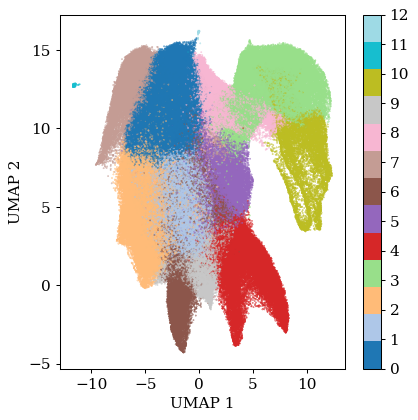

In [105]:
fig, ax = plt.subplots(1, 1, figsize=(5,5))
plt.rcParams['figure.dpi'] = 92
plt.rcParams['font.family'] = ['serif']
plt.rcParams['font.size'] = 12
plt.rcParams['axes.labelsize'] = 12
plt.rcParams['axes.titlesize'] = 12
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12
plot_umap(adata_concat,X_umap_label = "X_before_umap", column = "cluster",ax = ax,s = 0.1)

/tmp/ipykernel_1739687/1299109408.py:11: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  palette = plt.cm.get_cmap('Set2', num_clusters)


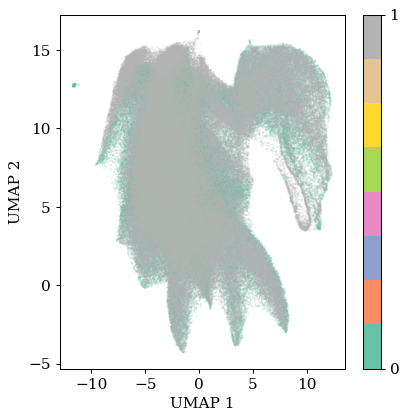

In [106]:
fig, ax = plt.subplots(1, 1, figsize=(5,5))
plt.rcParams['figure.dpi'] = 92
plt.rcParams['font.family'] = ['serif']
plt.rcParams['font.size'] = 12
plt.rcParams['axes.labelsize'] = 12
plt.rcParams['axes.titlesize'] = 12
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12
plot_umap(adata_concat,X_umap_label = "X_before_umap", column = "batch",paletteSel = 'Set2',ax = ax,s = 0.01)

/tmp/ipykernel_1739687/2130543508.py:10: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  plot_umap(ad_yes,X_umap_label = "X_before_umap", column = "batch",paletteSel = 'Set2',ax = ax,s = 0.1,specColor = plt.cm.get_cmap('Set2', 2)(0))
/tmp/ipykernel_1739687/1299109408.py:11: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  palette = plt.cm.get_cmap('Set2', num_clusters)


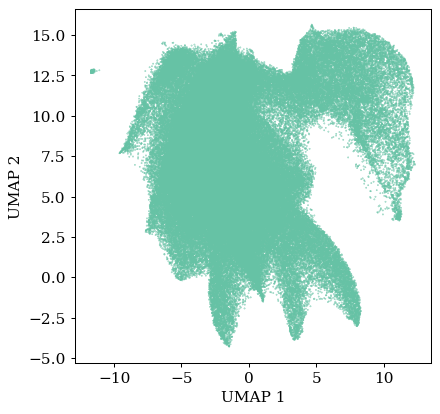

In [108]:
ad_yes = adata_concat[adata_concat.obs['batch']=="0",:].copy()
fig, ax = plt.subplots(1, 1, figsize=(5,5))
plt.rcParams['figure.dpi'] = 92
plt.rcParams['font.family'] = ['serif']
plt.rcParams['font.size'] = 12
plt.rcParams['axes.labelsize'] = 12
plt.rcParams['axes.titlesize'] = 12
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12
plot_umap(ad_yes,X_umap_label = "X_before_umap", column = "batch",paletteSel = 'Set2',ax = ax,s = 0.1,specColor = plt.cm.get_cmap('Set2', 2)(0))

/tmp/ipykernel_1739687/1759570954.py:10: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  plot_umap(ad_yes,X_umap_label = "X_before_umap", column = "batch",paletteSel = 'Set2',ax = ax,s = 0.1,specColor = plt.cm.get_cmap('Set2', 2)(1))
/tmp/ipykernel_1739687/1299109408.py:11: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  palette = plt.cm.get_cmap('Set2', num_clusters)


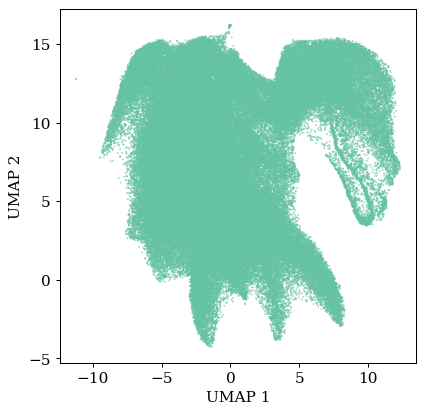

In [109]:
ad_yes = adata_concat[adata_concat.obs['batch']=="1",:].copy()
fig, ax = plt.subplots(1, 1, figsize=(5,5))
plt.rcParams['figure.dpi'] = 92
plt.rcParams['font.family'] = ['serif']
plt.rcParams['font.size'] = 12
plt.rcParams['axes.labelsize'] = 12
plt.rcParams['axes.titlesize'] = 12
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12
plot_umap(ad_yes,X_umap_label = "X_before_umap", column = "batch",paletteSel = 'Set2',ax = ax,s = 0.1,specColor = plt.cm.get_cmap('Set2', 2)(1))

In [ ]:
sc.pp.neighbors(adata_concat, n_pcs = 15, use_rep =  "X_pca_before",key_added = 'before')
sc.tl.leiden(adata_concat, random_state=1337, resolution=0.5, key_added='cluster', neighbors_key='before')
adata_concat